<a href="https://colab.research.google.com/github/afakharany93/SSL/blob/main/simsiam_with_gaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-supervised contrastive learning with SimSiam

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/03/19<br>
**Last modified:** 2023/12/29<br>
**Description:** Implementation of a self-supervised learning method for computer vision.

Self-supervised learning (SSL) is an interesting branch of study in the field of
representation learning. SSL systems try to formulate a supervised signal from a corpus
of unlabeled data points.  An example is we train a deep neural network to predict the
next word from a given set of words. In literature, these tasks are known as *pretext
tasks* or *auxiliary tasks*. If we [train such a network](https://arxiv.org/abs/1801.06146) on a huge dataset (such as
the [Wikipedia text corpus](https://www.corpusdata.org/wikipedia.asp)) it learns very effective
representations that transfer well to downstream tasks. Language models like
[BERT](https://arxiv.org/abs/1810.04805), [GPT-3](https://arxiv.org/abs/2005.14165),
[ELMo](https://allennlp.org/elmo) all benefit from this.

Much like the language models we can train computer vision models using similar
approaches. To make things work in computer vision, we need to formulate the learning
tasks such that the underlying model (a deep neural network) is able to make sense of the
semantic information present in vision data. One such task is to a model to _contrast_
between two different versions of the same image. The hope is that in this way the model
will have learn representations where the similar images are grouped as together possible
while the dissimilar images are further away.

In this example, we will be implementing one such system called **SimSiam** proposed in
[Exploring Simple Siamese Representation Learning](https://arxiv.org/abs/2011.10566). It
is implemented as the following:

1. We create two different versions of the same dataset with a stochastic data
augmentation pipeline. Note that the random initialization seed needs to be the same
during create these versions.
2. We take a ResNet without any classification head (**backbone**) and we add a shallow
fully-connected network (**projection head**) on top of it. Collectively, this is known
as the **encoder**.
3. We pass the output of the encoder through a **predictor** which is again a shallow
fully-connected network having an
[AutoEncoder](https://en.wikipedia.org/wiki/Autoencoder) like structure.
4. We then train our encoder to maximize the cosine similarity between the two different
versions of our dataset.


## Setup

In [ ]:
!pip install keras --upgrade
!pip install keras_cv

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import keras_cv
from keras import ops
from keras import layers
from keras import regularizers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

## Define hyperparameters

In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 5
CROP_TO = 32
SEED = 26

PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005

## Load the CIFAR-10 dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


## Defining our data augmentation pipeline

As studied in [SimCLR](https://arxiv.org/abs/2002.05709) having the right data
augmentation pipeline is critical for SSL systems to work effectively in computer vision.
Two particular augmentation transforms that seem to matter the most are: 1.) Random
resized crops and 2.) Color distortions. Most of the other SSL systems for computer
vision (such as [BYOL](https://arxiv.org/abs/2006.07733),
[MoCoV2](https://arxiv.org/abs/2003.04297), [SwAV](https://arxiv.org/abs/2006.09882),
etc.) include these in their training pipelines.

In [ ]:
strength = [0.4, 0.4, 0.3, 0.1]

random_flip = layers.RandomFlip(mode="horizontal_and_vertical")
random_crop = layers.RandomCrop(CROP_TO, CROP_TO)
random_brightness = layers.RandomBrightness(0.8 * strength[0])
random_contrast = layers.RandomContrast((1 - 0.8 * strength[1], 1 + 0.8 * strength[1]))
random_saturation = keras_cv.layers.RandomSaturation(
    (0.5 - 0.8 * strength[2], 0.5 + 0.8 * strength[2])
)
random_hue = keras_cv.layers.RandomHue(0.2 * strength[3], [0,255])
grayscale = keras_cv.layers.Grayscale()

def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = random_flip(image)
    image = random_crop(image)
    return image


def color_jitter(x):
    x = random_brightness(x)
    x = random_contrast(x)
    x = random_saturation(x)
    x = random_hue(x)
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = ops.clip(x, 0, 255)
    return x


def color_drop(x):
    x = grayscale(x)
    x = ops.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if keras.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image


It should be noted that an augmentation pipeline is generally dependent on various
properties of the dataset we are dealing with. For example, if images in the dataset are
heavily object-centric then taking random crops with a very high probability may hurt the
training performance.

Let's now apply our augmentation pipeline to our dataset and visualize a few outputs.

## Convert the data into TensorFlow `Dataset` objects

Here we create two different versions of our dataset *without* any ground-truth labels.

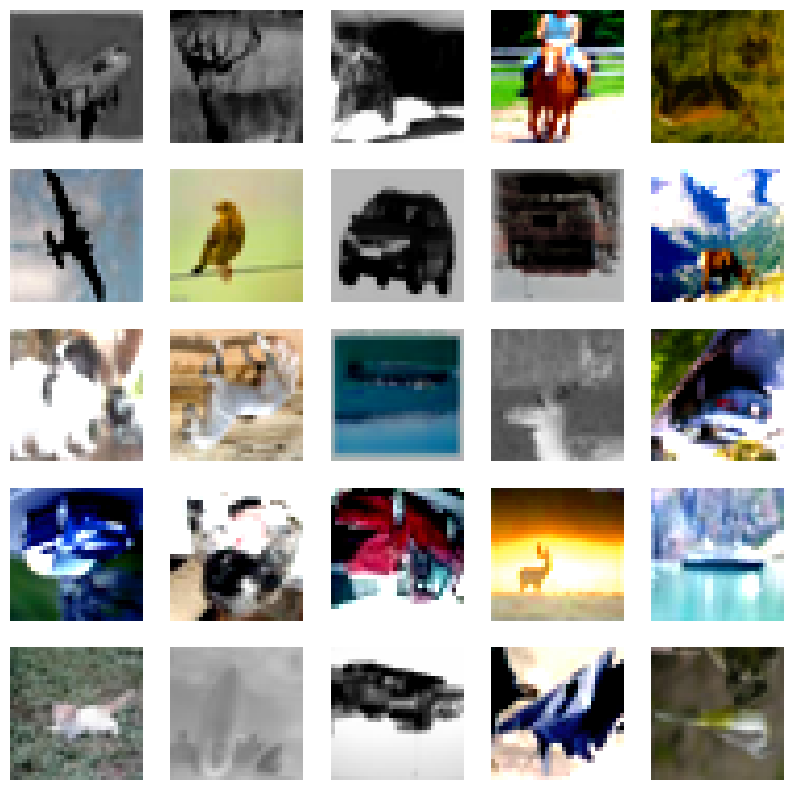

**********


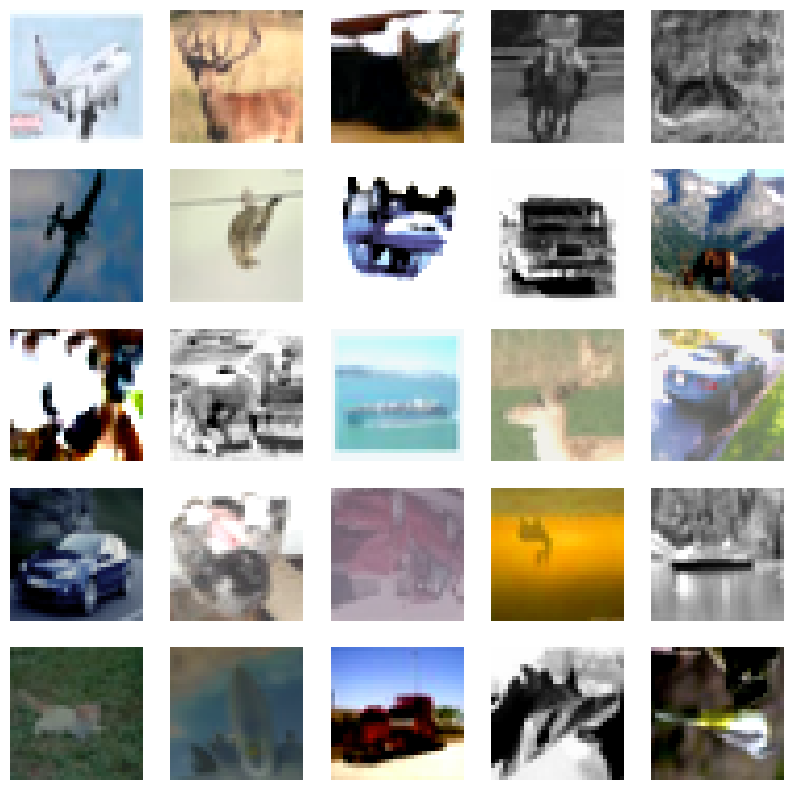

In [ ]:
ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

print('*'*10)

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

Notice that the images in `samples_images_one` and `sample_images_two` are essentially
the same but are augmented differently.

## Defining the encoder and the predictor

We use an implementation of ResNet20 that is specifically configured for the CIFAR10
dataset. The code is taken from the
[keras-idiomatic-programmer](https://github.com/GoogleCloudPlatform/keras-idiomatic-programmer/blob/master/zoo/resnet/resnet_cifar10_v2.py) repository. The hyperparameters of
these architectures have been referred from Section 3 and Appendix A of [the original
paper](https://arxiv.org/abs/2011.10566).

In [ ]:
!wget -q https://git.io/JYx2x -O resnet_cifar10_v2.py

In [ ]:
import resnet_cifar10_v2

N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1


def get_encoder():
    # Input and backbone.
    # You need to fill this part of the encoder and create your own
    # you can use functions like:
    # layers.Rescaling
    # layers.Dense
    # layers.BatchNormalization
    # layers.ReLU
    # layers.GlobalAveragePooling2D
    # resnet_cifar10_v2.stem
    #  resnet_cifar10_v2.learner

    inputs = layers.Input((CROP_TO, CROP_TO, 3))
    # add layers here

    # x = layers.GlobalAveragePooling2D(name="backbone_pool")(x) # a layer called "backbone_pool" is needed downstream

    # making the output similar to the porjection head.
    # add layers here
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    outputs = layers.BatchNormalization()(x)
    return keras.Model(inputs, outputs, name="encoder")


def get_predictor():
    model = keras.Sequential(
        [
            # You need to fill this part of the encoder and create your own
            # you can use functions like:
            # layers.Rescaling
            # layers.Dense
            # layers.BatchNormalization
            # layers.ReLU
            # layers.GlobalAveragePooling2D
            layers.Input((PROJECT_DIM,)),
            # add layers here

            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model


## Defining the (pre-)training loop

One of the main reasons behind training networks with these kinds of approaches is to
utilize the learned representations for downstream tasks like classification. This is why
this particular training phase is also referred to as _pre-training_.

We start by defining the loss function.

In [ ]:

def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    # p is the predictor output
    # z is the output of the second branch where the gradients are stopped
    # The functions you might need:
    # ops.stop_gradient
    # keras.utils.normalize
    # ops.mean
    # ops.sum

    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return


We then define our training loop by overriding the `train_step()` function of the
`keras.Model` class.

In [ ]:

class SimSiam(keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


## Pre-training our networks

In the interest of this example, we will train the model for only 5 epochs. In reality,
this should at least be 100 epochs.

In [ ]:
# Create a cosine decay learning scheduler.
num_training_samples = len(x_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = simsiam.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 218s 479ms/step - loss: -0.8185
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 171s 436ms/step - loss: -0.8874
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 211s 458ms/step - loss: -0.8929
Epoch 4/5
213/391 ━━━━━━━━━━━━━━━━━━━━ 1:18 443ms/step - loss: -0.8957

If your solution gets very close to -1 (minimum value of our loss) very quickly with a
different dataset and a different backbone architecture that is likely because of
*representation collapse*. It is a phenomenon where the encoder yields similar output for
all the images. In that case additional hyperparameter tuning is required especially in
the following areas:

* Strength of the color distortions and their probabilities.
* Learning rate and its schedule.
* Architecture of both the backbone and their projection head.

## Evaluating our SSL method

The most popularly used method to evaluate a SSL method in computer vision (or any other
pre-training method as such) is to learn a linear classifier on the frozen features of
the trained backbone model (in this case it is ResNet20) and evaluate the classifier on
unseen images. Other methods include
[fine-tuning](https://keras.io/guides/transfer_learning/) on the source dataset or even a
target dataset with 5% or 10% labels present. Practically, we can use the backbone model
for any downstream task such as semantic segmentation, object detection, and so on where
the backbone models are usually pre-trained with *pure supervised learning*.

In [ ]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone ResNet20.
backbone = keras.Model(
    simsiam.encoder.input, simsiam.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
backbone.trainable = False
inputs = layers.Input((CROP_TO, CROP_TO, 3))
x = backbone(inputs, training=False)
outputs = layers.Dense(10, activation="softmax")(x)
linear_model = keras.Model(inputs, outputs, name="linear_model")

# Compile model and start training.
linear_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
history = linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
_, test_acc = linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

## Notes
* More data and longer pre-training schedule benefit SSL in general.
* SSL is particularly very helpful when you do not have access to very limited *labeled*
training data but you can manage to build a large corpus of unlabeled data. Recently,
using an SSL method called [SwAV](https://arxiv.org/abs/2006.09882), a group of
researchers at Facebook trained a [RegNet](https://arxiv.org/abs/2006.09882) on 2 Billion
images. They were able to achieve downstream performance very close to those achieved by
pure supervised pre-training. For some downstream tasks, their method even outperformed
the supervised counterparts. You can check out [their
paper](https://arxiv.org/pdf/2103.01988.pdf) to know the details.
* If you are interested to understand why contrastive SSL helps networks learn meaningful
representations, you can check out the following resources:
   * [Self-supervised learning: The dark matter of
intelligence](https://ai.facebook.com/blog/self-supervised-learning-the-dark-matter-of-intelligence/)
   * [Understanding self-supervised learning using controlled datasets with known
structure](https://sslneuips20.github.io/files/CameraReadys%203-77/64/CameraReady/Understanding_self_supervised_learning.pdf)